In [1]:
!nvidia-smi

Sat Feb 20 14:01:33 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.104      Driver Version: 410.104      CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-DGXS...  On   | 00000000:07:00.0 Off |                    0 |
| N/A   47C    P0    51W / 300W |    765MiB / 32478MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-DGXS...  On   | 00000000:08:00.0 Off |                    0 |
| N/A   45C    P0    55W / 300W |   3801MiB / 32478MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [2]:
# using gpu:/1
import tensorflow as tf
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#   try:
#     tf.config.experimental.set_memory_growth(gpus[0], True)
#   except RuntimeError as e:
#     print(e)

## Dataset 분할

---

`Train` : `Test` = 0.75 : 0.25

- test

0-19 = 100명<br>
20-49 = 75명<br>
50- = 51명<br>

= 226 * 4 = 804개의 image

- train


0-19 = 299명

20-49 = 225명

50- = 154명

= 678 * 4 = 2712개의 image

In [3]:
import os
path_dir1 = '../sungjin/tooth/train/'
path_dir2 = '../sungjin/tooth/test/'

sub_directory = ['0/','20/','50/']

TRAIN_NUM = 0
TEST_NUM = 0

for subdir in sub_directory:
    tmp_list = os.listdir(path_dir1+subdir)
    TRAIN_NUM += len(tmp_list)
    
for subdir in sub_directory:
    tmp2_list = os.listdir(path_dir2+subdir)
    TEST_NUM += len(tmp2_list)
    

In [4]:
# the number of training data = 2812
print(TRAIN_NUM)

2643


In [5]:
# the number of test data = 804
print(TEST_NUM)

677


In [6]:
import numpy as np

# preprocessing image

train_img = np.float32(np.zeros((TRAIN_NUM,224,224,3)))
train_label = np.uint8(np.zeros((TRAIN_NUM,)))

test_img = np.float32(np.zeros((TEST_NUM,224,224,3)))
test_label = np.uint8(np.zeros((TEST_NUM,)))

## Make Label

---

ImageDataGenerator는 directory별로 data augmentation

--> 두가지 네트워크를 비교했을 때 둘다 prediction에서 문제가 생김

따라서, 라벨링을 통해 다시한번 실험중

In [7]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input

make_label = [0,1,2]

num = 0
idx = 0
for subdir in sub_directory:
    give_label = make_label[idx]
    for file in os.listdir(path_dir1+subdir):
        src_path = path_dir1 + subdir + file
        img = load_img(src_path, target_size = (224,224))

        x = img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        
        train_img[num, :, :, :] = x

        train_label[num] = give_label
        num = num + 1
    idx += 1

In [8]:
num = 0
idx = 0

for subdir in sub_directory:
    give_label = make_label[idx]
    for file in os.listdir(path_dir2+subdir):
        src_path = path_dir2 + subdir + file
        img = load_img(src_path, target_size = (224,224))

        x = img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        
        test_img[num, :, :, :] = x

        test_label[num] = give_label
        num = num + 1
    idx += 1

In [9]:
import keras

train_label = keras.utils.to_categorical(train_label,3)
test_label = keras.utils.to_categorical(test_label,3)

## Data Augmentation

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# create a data generator

datagen = ImageDataGenerator(
#         zoom_range = 0.2, # 경계선부근에 치아가 있는경우 치아정보 손실가능성 증가
        brightness_range = [0.7,1.3],
        rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
        horizontal_flip=True,  # randomly flip images left and right
        vertical_flip=True)  # randomly flip images upside down

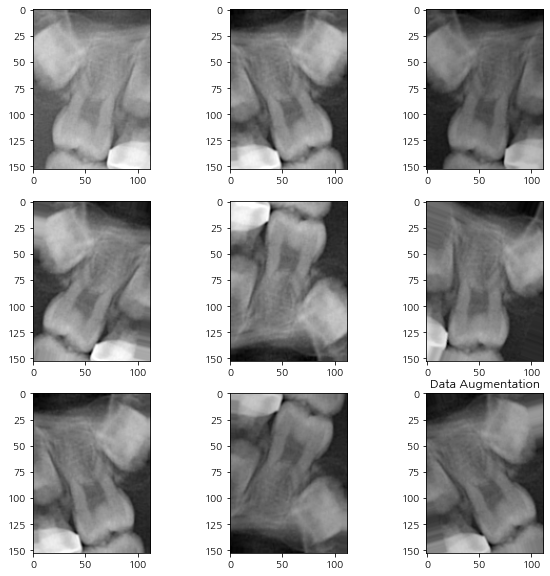

In [11]:
import matplotlib.pyplot as plt
# 첫 번째 차원을 추가하여 확장
img = load_img('../sungjin/tooth/test/0/20681492 박서현 16.png')
data = img_to_array(img)
samples = np.expand_dims(data, 0)

datagen.fit(train_img)
datagen.fit(test_img)


it = datagen.flow(samples, batch_size=32)

fig = plt.figure(figsize = (10,10))

plt.subplot(3,3,1)
plt.imshow(img)

# 9개 이미지 생성
for i in range(8):
    plt.subplot(3, 3, i+2)
    batch = it.next()
    image = batch[0].astype('uint8')
    plt.imshow(image)

# show the figure
plt.title("Data Augmentation")
plt.show()

## Transfer Learning

In [12]:
from tensorflow.python.keras.callbacks import EarlyStopping, TensorBoard
es = EarlyStopping(patience=10, monitor='val_acc')
tb = TensorBoard(log_dir='../sungjin/log/GAP')

In [15]:
log_dir="../sungjin/log/GAP"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [ ]:
import tensorflow as tf
from keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,AveragePooling2D,Flatten,Dropout,GlobalAveragePooling2D,BatchNormalization, LeakyReLU
from tensorflow import keras
from sklearn.metrics import recall_score 
from sklearn.metrics import precision_score 
from sklearn.metrics import f1_score 
from sklearn.preprocessing import label_binarize

with tf.device('/gpu:1'):
    base_model = keras.applications.ResNet152(
        include_top=False,
        weights="imagenet",
        input_shape=(224,224,3)
    )
    
    x = keras.layers.GlobalAveragePooling2D()(base_model.output)
    x = keras.layers.Dense(2048,activation = 'relu')(x)
    x = keras.layers.Dropout(0.5)(x)
#     x = keras.layers.AveragePooling2D(pool_size = (7,7))(base_model.output)
#     x = keras.layers.Flatten()(x)
#     x = keras.layers.Dense(128,activation= 'relu')(x)
#     x = keras.layers.Dropout(0.5)(x)
    
    predictions = keras.layers.Dense(3,activation = 'softmax')(x)

    model = keras.models.Model(inputs = base_model.input,outputs =predictions)

    model.compile(optimizer = keras.optimizers.Adam(lr = 0.00001),
                  loss = 'categorical_crossentropy',
                  metrics = ['accuracy',])
    
    history = model.fit(datagen.flow(train_img,train_label,batch_size=32),
                        validation_data=datagen.flow(test_img,test_label,batch_size =32),
                        batch_size = 32,
                        epochs=30,
                        callbacks=[tensorboard_callback])

#     model.save("afterDelete_GAP.h5")

Epoch 1/30
83/83 [==============================] - 48s 582ms/step - loss: 0.9341 - accuracy: 0.5721 - val_loss: 0.8674 - val_accuracy: 0.5938
Epoch 2/30
83/83 [==============================] - 45s 539ms/step - loss: 0.6928 - accuracy: 0.6788 - val_loss: 0.6945 - val_accuracy: 0.6869
Epoch 3/30
83/83 [==============================] - 45s 538ms/step - loss: 0.5873 - accuracy: 0.7283 - val_loss: 0.6456 - val_accuracy: 0.6809
Epoch 4/30
83/83 [==============================] - 44s 535ms/step - loss: 0.5416 - accuracy: 0.7431 - val_loss: 0.5881 - val_accuracy: 0.7400
Epoch 5/30
83/83 [==============================] - 44s 533ms/step - loss: 0.4824 - accuracy: 0.7692 - val_loss: 0.5711 - val_accuracy: 0.7356
Epoch 6/30
83/83 [==============================] - 45s 539ms/step - loss: 0.4545 - accuracy: 0.7919 - val_loss: 0.5956 - val_accuracy: 0.7267
Epoch 7/30
83/83 [==============================] - 45s 539ms/step - loss: 0.4231 - accuracy: 0.8135 - val_loss: 0.5354 - val_accuracy: 0.7725

In [ ]:
# # base_model.trainable = False

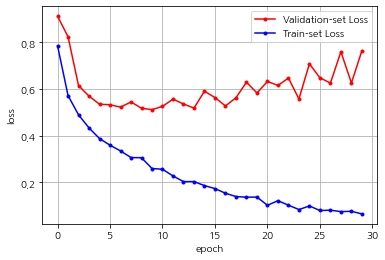

In [15]:
import numpy as np
import matplotlib.pyplot as plt

y_vloss = history.history['val_loss']
y_loss = history.history['loss']

x_len = np.arange(len(y_loss))


plt.plot(x_len, y_vloss, marker='.', c='red', label="Validation-set Loss")
plt.plot(x_len, y_loss, marker='.', c='blue', label="Train-set Loss")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

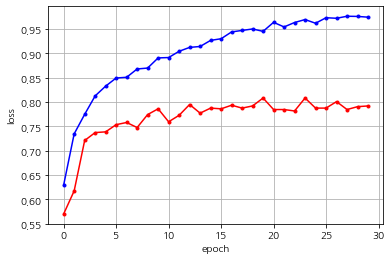

In [16]:
y_vacc = history.history['val_accuracy']
y_acc = history.history['accuracy']

x_len = np.arange(len(y_acc))

plt.plot(x_len, y_vacc, marker='.', c='red')
plt.plot(x_len, y_acc, marker='.', c='blue')

plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

## Predict 

In [ ]:
# from keras.models import load_model

# model = load_model("FC.h5")

In [17]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing import image as image_utils
from tensorflow.keras.applications.imagenet_utils import preprocess_input

In [18]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import os

path = '../sungjin/tooth5/test/'
subdir = ['0/','20/','50/']
num = 0
idx = 0
count = 0

for sub in subdir:
    num = 0
    count = 0
    print("                                            "+subdir[idx])
    print("--------------------------------------------------------------------------------------")
    for file in os.listdir(path+sub):
        src_path = path + sub+file
        img = load_img(src_path, target_size = (224,224))

        x = img_to_array(img)
        x = x.reshape(1,224,224,3)
        x = preprocess_input(x)
        preds = model.predict(x)
        if np.argmax(preds)==idx:
            count+=1
            print("T", end = ' ')
        else :
            print("F", end = ' ')
        num = num + 1
        
        if num == 50:
            print(" ")
            print("총 50개 중에"+repr(count)+"개 맞혔습니다.")
            print(repr((count/50)*100)+"% prediction")
            print()
            break
            
    idx +=1
    print(" ")
    


                                            0/
--------------------------------------------------------------------------------------
F F T T T T T T T T T T T T T T T F T T F T T T T F T T T T T T F T T T T F T T T T T T T T F T T T  
총 50개 중에42개 맞혔습니다.
84.0% prediction

 
                                            20/
--------------------------------------------------------------------------------------
T F F T T T T F T T T T T T T T T T T T T F T T T T T T T F T T T T T T T T T F T T T T T T T T F F  
총 50개 중에42개 맞혔습니다.
84.0% prediction

 
                                            50/
--------------------------------------------------------------------------------------
T T T T F T T T T T T T T T F T T T F T T T T T T T T T T F T T T T F F T T F F T T T T F T T T T T  
총 50개 중에41개 맞혔습니다.
82.0% prediction

 


## Grad-CAM

In [19]:

from keras import layers
from keras import models
from keras import backend as K
import cv2

import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing import image as image_utils
from tensorflow.keras.applications.imagenet_utils import preprocess_input

In [20]:
def gradCAM(image):
    conv_layer = model.get_layer("conv5_block3_3_conv")
    heatmap_model = models.Model([model.inputs],[conv_layer.output,model.output])

    with tf.GradientTape() as gtape:
        conv_output, predictions = heatmap_model(image) # y^c, c
        loss = predictions[:, np.argmax(predictions[0])] # probability
        grads = gtape.gradient(loss, conv_output) # partial-derivative
        pooled_grads = K.mean(grads, axis=(0, 1, 2)) # a_k^c , weight

    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_output), axis=-1) # summation weight * filter
    heatmap = np.maximum(heatmap, 0) # ReLu
    max_heat = np.max(heatmap) # normalization    


    if max_heat == 0:
        max_heat = 1e-10
    heatmap /= max_heat
    
    image = image[0]
    image = cv2.resize(image, (112,153))

    hm = heatmap[0]
    hm = cv2.resize(hm, (image.shape[1],image.shape[0]))
    hm = np.uint8(255*hm)
    hm = cv2.applyColorMap(hm,cv2.COLORMAP_JET)

    cvt_heatmap = cv2.cvtColor(hm, cv2.COLOR_BGR2RGB)

    superimposed_img = cvt_heatmap * 0.3 + image

    superimposed_img[superimposed_img > 255] = 255
    superimposed_img = superimposed_img.astype('uint8')


    return superimposed_img,np.argmax(predictions[0])

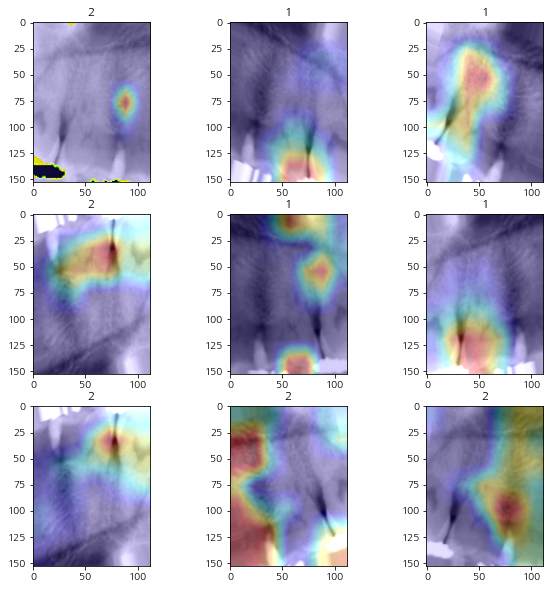

In [21]:
import matplotlib.pyplot as plt
# 첫 번째 차원을 추가하여 확장

img_path = '../sungjin/tooth5/test/0/20323665 한하은 26.png' # 제대로됨
# img_path = '../sungjin/tooth5/test/20/20328047 이지수 16.png' # 제대로됨
# img_path = '../sungjin/tooth5/test/20/20103381 이혜정 26.png' # 1개 오류
# img_path = '../sungjin/tooth5/test/20/20108982 서윤경 16.png' #w
# img_path = '../sungjin/tooth5/test/20/20111069 한은영 16.png'
# img_path = '../sungjin/tooth5/test/20/20212220 이영원 16.png'
# img_path = '../sungjin/tooth5/test/20/20272160 김영석 16.png'
# img_path = '../sungjin/tooth3/test/under50/20683982 기선미 16.png'

image = image_utils.load_img(img_path)
image = image_utils.img_to_array(image)
image = np.expand_dims(x,axis = 0)
x = preprocess_input(x)

datagen.fit(train_img)
datagen.fit(test_img)


it = datagen.flow(x, batch_size=32)
fig = plt.figure(figsize = (10,10))

plt.subplot(3,3,1)
a,b = gradCAM(x)
plt.imshow(a)
plt.title(np.argmax(model.predict(x)))

# layer which calculate `score class`


# 9개 이미지 생성
for i in range(8):
    plt.subplot(3, 3, i+2)
    batch = it.next()
    
#     image = batch[0].astype('uint8')
    image,predict = gradCAM(batch)
    plt.imshow(image)
    plt.title(predict)

# show the figure
plt.show()

## ROC-AUC

In [22]:
# labels = [0, 1, 2]

# ytest  = [0,1,2,3,2,2,1,0,1]

# # Binarize ytest with shape (n_samples, n_classes)
# ytest = label_binarize(ytest, classes=labels)

# ypreds = [1,2,1,3,2,2,0,1,1]

# # Binarize ypreds with shape (n_samples, n_classes)
# ypreds = label_binarize(ypreds, classes=labels)


# roc_auc_score(ytest, ypreds,average='macro',multi_class='ovo')

In [23]:
import pandas as pd
from sklearn.metrics import roc_auc_score,roc_curve,accuracy_score,recall_score
p = model.predict(test_img, verbose=True)
pre = pd.DataFrame(p)

22/22 [==============================] - 2s 69ms/step


In [24]:
pre["predict"] = pre.idxmax(axis=1)
pre["predict"] = (pre["predict"]==0).apply(int)
label = np.argmax(test_label,axis = 1).reshape(-1,1)
pre["label"] = label
pre["label"] = (pre["label"]==0).apply(int)

In [25]:
recall_score(pre["label"],pre["predict"])

0.7492063492063492

In [26]:
roc_auc_score(pre["label"],pre["predict"])

0.8469788652109095

In [27]:
p = model.predict(test_img, verbose=True)
pre = pd.DataFrame(p)

pre["predict"] = pre.idxmax(axis=1)
pre["predict"] = (pre["predict"]==1).apply(int)
label = np.argmax(test_label,axis = 1).reshape(-1,1)
pre["label"] = label
pre["label"] = (pre["label"]==1).apply(int)

recall_score(pre["label"],pre["predict"])


22/22 [==============================] - 2s 68ms/step


0.7811158798283262

In [28]:
roc_auc_score(pre["label"],pre["predict"])

0.7847020840583072

In [29]:
p = model.predict(test_img, verbose=True)
pre = pd.DataFrame(p)

pre["predict"] = pre.idxmax(axis=1)
pre["predict"] = (pre["predict"]==1).apply(int)
label = np.argmax(test_label,axis = 1).reshape(-1,1)
pre["label"] = label
pre["label"] = (pre["label"]==1).apply(int)

recall_score(pre["label"],pre["predict"])


22/22 [==============================] - 2s 69ms/step


0.7811158798283262

In [30]:
roc_auc_score(pre["label"],pre["predict"])

0.7847020840583072

In [31]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}